# OCR mediante Docling de IBM

 - Segmentando y extrayendo la informacion en JSON de cada una de las páginas del PDF facilitado
 - Todo el codigo siguiente ha sido optenido de: https://ds4sd.github.io/docling/examples/export_multimodal/

In [ ]:
import datetime
import logging
import time
from pathlib import Path
import pandas as pd


In [2]:
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.utils.export import generate_multimodal_pages
from docling.utils.utils import create_hash

In [3]:
_log = logging.getLogger(__name__)

In [5]:
IMAGE_RESOLUTION_SCALE = 1.0

 ### Funcion que parsea el PDF y exporta un arhivo formato parquet 

In [ ]:
def OCR_Multiple_Export(input_doc_path: str, output_dir: str):
    logging.basicConfig(level=logging.INFO)
    
    # Archivo input
    input_doc_path = Path(input_doc_path)
    # Carpeta destino
    output_dir = Path(output_dir)

    # Objeto para definir el proceso de OCR
    pipeline_options = PdfPipelineOptions()
    # Resolucion de la imagen guardada
    pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
    # Parsing por pagina
    pipeline_options.generate_page_images = True

    # Se declara  la funcion para el OCR utilizando las configuraciones especificas
    doc_converter = DocumentConverter(
        format_options={
            InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
        }
    )

    start_time = time.time()
    # Se ejecuta el OCR con el documento de entrada
    conv_res = doc_converter.convert(input_doc_path)
    # Se crea la carpeta en el directorio definido
    output_dir.mkdir(parents=True, exist_ok=True)

    # Se recorre todas las paginas obtenidas por el DocumentConverter para extraer cada tipo de 
    # formato de dato mediante el objeto que engloba distintos modelos: generate_multimodal_pages()
    rows = []
    for (
        content_text,
        content_md,
        content_dt,
        page_cells,
        page_segments,
        page,
    ) in generate_multimodal_pages(conv_res):

        dpi = page._default_image_scale * 72
    # Se apendiza el JSON con anidacion con el todo el contenido de cada iteracion
        rows.append(
            {
                "document": conv_res.input.file.name,
                "hash": conv_res.input.document_hash,
                "page_hash": create_hash(
                    conv_res.input.document_hash + ":" + str(page.page_no - 1)
                ),
                "image": {
                    "width": page.image.width,
                    "height": page.image.height,
                    "bytes": page.image.tobytes(),
                },
                "cells": page_cells,
                "contents": content_text,
                "contents_md": content_md,
                "contents_dt": content_dt,
                "segments": page_segments,
                "extra": {
                    "page_num": page.page_no + 1,
                    "width_in_points": page.size.width,
                    "height_in_points": page.size.height,
                    "dpi": dpi,
                },
            }
        )

    # Se genera un DataFrame
    df = pd.json_normalize(rows)
    now = datetime.datetime.now()
    output_filename = output_dir / f"multimodal_{now:%Y-%m-%d_%H%M%S}.parquet"
    # Se guarda como un archivo .parquet
    df.to_parquet(output_filename)

    end_time = time.time() - start_time

    _log.info(
        f"Document converted and multimodal pages generated in {end_time:.2f} seconds."
    )
    return str(output_filename)


### Test con la publicacion academica de Florence-2

In [ ]:
target_file = 'Florence-2.pdf'
final_directory = 'Test_Florence2'
export_file_path = OCR_Multiple_Export(target_file, final_directory)

INFO:docling.document_converter:Going to convert document batch...
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 9007.10it/s]
INFO:docling.pipeline.base_pipeline:Processing document Florence-2.pdf
INFO:docling.document_converter:Finished converting document Florence-2.pdf in 90.47 sec.
INFO:__main__:Document converted and multimodal pages generated in 91.06 seconds.


In [ ]:
# Se lee el archivo .parquet.
multimodal_df = pd.read_parquet(export_file_path)

In [16]:
from datasets import Dataset
from PIL import Image

# Se convierte el Dataframe al formato de Dataset, formato optimizado cuando se utilizan herramientas de Huggin Face
dataset = Dataset.from_pandas(multimodal_df)
# Funcion para poder visualizar las imagenes. Reconstruccion mediante los bytes de las imagenes anteriormente extraido.
def transforms(examples):
         examples["image"] = Image.frombytes('RGB', (examples["image.width"], examples["image.height"]), examples["image.bytes"], 'raw')
         return examples

dataset = dataset.map(transforms)

INFO:datasets:PyTorch version 2.5.1 available.
Map: 100%|██████████| 35/35 [00:01<00:00, 28.08 examples/s]


In [19]:
dataset.features

{'document': Value(dtype='string', id=None),
 'hash': Value(dtype='string', id=None),
 'page_hash': Value(dtype='string', id=None),
 'cells': [{'bbox': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None),
   'ocr': Value(dtype='bool', id=None),
   'ocr_confidence': Value(dtype='float64', id=None),
   'text': Value(dtype='string', id=None)}],
 'contents': Value(dtype='string', id=None),
 'contents_md': Value(dtype='string', id=None),
 'contents_dt': Value(dtype='string', id=None),
 'segments': [{'bbox': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None),
   'data': [{'html_seq': Value(dtype='string', id=None),
     'otsl_seq': Value(dtype='string', id=None)}],
   'index_in_doc': Value(dtype='int64', id=None),
   'label': Value(dtype='string', id=None),
   'text': Value(dtype='string', id=None)}],
 'image.width': Value(dtype='int64', id=None),
 'image.height': Value(dtype='int64', id=None),
 'image.bytes': Value(dtype='binary', id=None),
 'extra.page_

{'bbox': [0.5034954095977584, 0.30377120201033775, 0.8892027412364686, 0.5058443088724156], 'data': [], 'index_in_doc': 13, 'label': 'picture', 'text': 'Figure 1. We aim to build a vision foundation model to enable extensive perception capabilities including spatial hierarchy and semantic granularity. To achieve this, a single unified model Florence-2 is pre-trained on our FLD-5B dataset encompassing a total of 5.4B comprehensive annotations across 126M images, which are collected by our Florence data engine.'}


### Extraccion de la imagen mediante los segmentos

#### Pagina de donde extraer la imagen

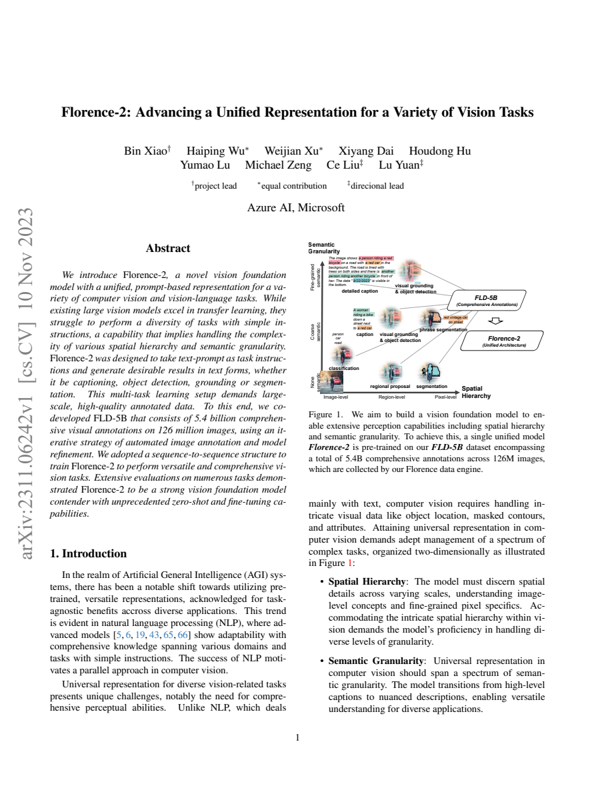

In [21]:
dataset[0]['image']

#### Uso de los segmentos para extraer solo el diagrama

In [25]:
# Se recorren los segmentos generados en la pagina 0, guardando unicamente aquellos
# que poseean la etiqueta de imagen, en nuestro caso, el diagrama.
for segment in dataset[0]["segments"]:
    if segment['label'] == 'picture':
        bbox = segment['bbox']

print(f'Coordenandas del diagrama en la pagina {bbox}')

Coordenandas del diagrama en la pagina [0.5034954095977584, 0.30377120201033775, 0.8892027412364686, 0.5058443088724156]


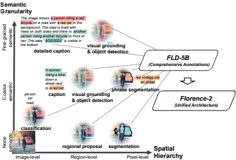

In [26]:
# Se extrae el tamanio de la imagen
image_width, image_height = dataset[0]['image'].size

# Convertir coordenadas normalizadas a píxeles
left = int(bbox[0] * image_width)
top = int(bbox[1] * image_height)
right = int(bbox[2] * image_width)
bottom = int(bbox[3] * image_height)
# Se recorta la imagen para solo centrarse en el diagrama obtenido por los segmentos
cropped_image = dataset[0]['image'].crop((left, top, right, bottom))

# Guardar o mostrar la región recortada
cropped_image

Como se puede observar, Docling nos habilita la deteccion de las imagenes. En el caso de este proyecto, generalmente seran diagramas o graficas. Siendo de gran utilidad para posteriormente generar la anotacion de esta imagen recortada.